# Setup

In [19]:
import pandapower.networks as pnet
import pandas as pd
import numpy as np
import scipy as sp
import cvxpy as cp
import seaborn as sns
import mlflow

from scipy import sparse

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import sys
sys.path.insert(1, '..')

from src.models.matrix_operations import make_real_vector, vectorize_matrix
from src.simulation.noise import add_polar_noise_to_measurement
from src.simulation.network import cross_multiply_measurements, make_measurements_matrix
from src.models.noise_transformation import power_covariance
from src.models.regression import ComplexRegression, ComplexLasso
from src.models.error_in_variable import TotalLeastSquares, SparseTotalLeastSquare
from src.simulation.load_profile import generate_gaussian_load
from src.simulation.network import add_load_power_control, make_y_bus
from src.simulation.simulation import run_simulation, get_current_and_voltage
from src.identification.error_metrics import error_metrics, fro_error
from src.models.noise_transformation import average_true_noise_covariance

# Network simulation

In [22]:
mlflow.set_experiment('Full network with polar noise')

In [23]:
net = pnet.create_kerber_landnetz_freileitung_2()
nodes = net.bus.shape[0]
steps = 400
load_cv = 0.2
current_magnitude_sd = 0.000001
voltage_magnitude_sd = 0.0001
phase_sd = 0.0001

In [24]:
np.random.seed(11)
load_p, load_q = generate_gaussian_load(net.load.p_mw, net.load.q_mvar, load_cv, steps)
controlled_net = add_load_power_control(net, load_p, load_q)
sim_result = run_simulation(controlled_net, verbose=False)
y_bus = make_y_bus(controlled_net)
voltage, current = get_current_and_voltage(sim_result, y_bus)
controlled_net.bus

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps


,name,vn_kv,type,zone,in_service
0,Trafostation_OS,10.0,b,None,True
1,main_busbar,0.4,b,None,True
2,bus_1_1,0.4,b,None,True
3,bus_1_2,0.4,b,None,True
4,bus_1_3,0.4,b,None,True
5,bus_1_4,0.4,b,None,True
6,bus_1_5,0.4,b,None,True
7,bus_1_6,0.4,b,None,True
8,bus_2_1,0.4,b,None,True
9,bus_2_2,0.4,b,None,True


In [25]:
voltage = voltage[:, 1:]
y_bus = y_bus[1:, 1:]
current = np.array(voltage @ y_bus)
noisy_voltage = add_polar_noise_to_measurement(voltage, voltage_magnitude_sd, phase_sd)
noisy_current = add_polar_noise_to_measurement(current, current_magnitude_sd, phase_sd)
voltage_error, current_error = noisy_voltage - voltage, noisy_current - current

real_powers = np.multiply(voltage,current.conj())
powers = np.multiply(noisy_voltage,noisy_current.conj())

real_line_mat = cross_multiply_measurements(voltage)
line_mat = cross_multiply_measurements(noisy_voltage)

real_A_mat = make_measurements_matrix(voltage)
A_mat = make_measurements_matrix(noisy_voltage)

power_noise = powers - real_powers
line_mat_noise = line_mat - real_line_mat

b_vector = powers.reshape(powers.size)

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
np.linalg.svd(voltage, compute_uv=False)

array([5.89221591e+01, 4.25232562e-02, 1.35369650e-02, 5.73441653e-03,
       2.75443540e-03, 2.25199217e-03, 1.55263364e-03, 1.16434339e-03,
       9.41492168e-04])

In [27]:
np.mean(np.abs(current), 0)

array([2.49996625, 0.00810926, 0.00811186, 0.00817258, 0.00823941,
       0.00830128, 0.00824192, 0.00803008, 0.0081679 ])

In [28]:
mlflow_params = {
    'nodes': noisy_voltage.shape[1],
    'steps': steps,
    'load_cv': load_cv,
    'current_magnitude_sd': current_magnitude_sd,
    'voltage_magnitude_sd': voltage_magnitude_sd,
    'phase_sd': phase_sd
}

# OLS Identification

In [29]:
with mlflow.start_run(run_name='OLS'):
    ols = ComplexRegression()
    ols.fit(A_mat, b_vector)
    y_ols = ols.fitted_admittance_matrix.reshape(y_bus.shape).conj()
    ols_metrics = error_metrics(y_bus, y_ols)
    mlflow.log_params(mlflow_params)
    mlflow.log_metrics(ols_metrics.__dict__)
ols_metrics

ErrorMetrics(fro_error=46.517583454731216, max_error=15.373995461808203, rrms_error=0.808249812802021, map_error=0.7803992237588511)

# Lasso Identification

In [30]:
with mlflow.start_run(run_name='Lasso'):
    lasso = ComplexLasso(y_bus, verbose=False, lambdas=np.logspace(-12, -1, 40), solver=cp.GUROBI)
    lasso.fit(A_mat, b_vector, True)
    y_lasso = lasso.fitted_admittance_matrix.conj().T
    lasso_metrics = error_metrics(y_bus, y_lasso)
    mlflow.log_params(mlflow_params)
    mlflow.log_metrics(lasso_metrics.__dict__)
best_lambda = lasso.best_trial.hyperparameters['lambda']
lasso_metrics

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:323: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  return self.solver.solve_via_data(data, warm_start, verbose,


ErrorMetrics(fro_error=46.517583392168035, max_error=15.37399546356872, rrms_error=0.8082498117149766, map_error=0.7803992225611119)

In [31]:
best_lambda

1.8047217668271666e-10

# TLS Identification

In [32]:
with mlflow.start_run(run_name='TLS'):
    tls = TotalLeastSquares()
    tls.fit(A_mat, b_vector)
    y_tls = tls.fitted_admittance_matrix.reshape(y_bus.shape).conj()
    tls_metrics = error_metrics(y_bus, y_tls)
    mlflow.log_params(mlflow_params)
    mlflow.log_metrics(tls_metrics.__dict__)
tls_metrics

[[-0.01417732+0.00568496j]]


ErrorMetrics(fro_error=24.572545857937747, max_error=8.112392952910335, rrms_error=0.4269515764737616, map_error=0.20593965050709076)

# L1 Regularized TLS without covariance

In [67]:
with mlflow.start_run(run_name='S-TLS no covariance'):
    max_iterations = 500
    abs_tol = 10e-12
    rel_tol = 10e-12
    solver = cp.GUROBI
    use_cov_matrix = False

    sparse_tls = SparseTotalLeastSquare(lambda_value=best_lambda, abs_tol=abs_tol, rel_tol=rel_tol, solver=solver, max_iterations=max_iterations)
    sparse_tls.fit_with_vectored_data(line_mat, A_mat, b_vector)

    y_sparse_tls = sparse_tls.fitted_admittance_matrix.conj()
    sparse_tls_metrics = error_metrics(y_bus, y_sparse_tls)

    sparse_tls_errors = pd.Series([fro_error(y_bus.conj(), i.fitted_parameters) for i in sparse_tls.iterations])
    sparse_tls_targets = pd.Series([i.target_function for i in sparse_tls.iterations])

    mlflow.log_param('lambda', best_lambda)
    mlflow.log_param('max_iterations', max_iterations)
    mlflow.log_param('abs_tol', abs_tol)
    mlflow.log_param('rel_tol', rel_tol)
    mlflow.log_param('solver', solver)
    mlflow.log_param('use_cov_matrix', use_cov_matrix)
    mlflow.log_params(mlflow_params)
    mlflow.log_metrics(sparse_tls_metrics.__dict__)

    for i in range(len(sparse_tls_errors)):
        mlflow.log_metric('fro_error_evo', value=sparse_tls_errors[i], step=i)
        mlflow.log_metric('opt_cost_evo', value=sparse_tls_targets[i], step=i)

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:323: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  return self.solver.solve_via_data(data, warm_start, verbose,
100%|██████████| 500/500 [17:57<00:00,  2.16s/it]


/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

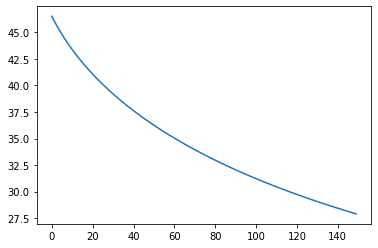

In [65]:
sparse_tls_errors.plot()

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

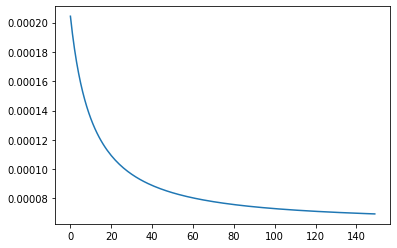

In [66]:
sparse_tls_targets.plot()

# Covariance calculations

This easily takes 10 minutes, it's the longest cell by far.

In [53]:
sigma_power = power_covariance(noisy_voltage.reshape(noisy_voltage.size), noisy_current.reshape(noisy_current.size),
                           voltage_magnitude_sd, phase_sd, current_magnitude_sd, phase_sd)
voltages1 = noisy_voltage.repeat(noisy_voltage.shape[1],1).flatten()
voltages2 = np.tile(noisy_voltage, (1, noisy_voltage.shape[1])).flatten()
sigma_line_mat = power_covariance(voltages1, voltages2, voltage_magnitude_sd, phase_sd, voltage_magnitude_sd, phase_sd)

inv_sigma_power = sparse.linalg.inv(sigma_power)
inv_sigma_line_mat = sparse.linalg.inv(sigma_line_mat)

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# L1 Regularized TLS with covariance

In [54]:
with mlflow.start_run(run_name='S-TLS with covariance'):
    max_iterations = 150
    abs_tol = 10e-12
    rel_tol = 10e-12
    solver = cp.GUROBI
    use_cov_matrix = True

    sparse_tls_cov = SparseTotalLeastSquare(lambda_value=best_lambda, abs_tol=abs_tol, rel_tol=rel_tol, solver=solver, max_iterations=max_iterations)
    sparse_tls_cov.fit_with_vectored_data(line_mat, A_mat, b_vector, inv_sigma_line_mat, inv_sigma_power)

    y_sparse_tls_cov = sparse_tls_cov.fitted_admittance_matrix.conj()
    sparse_tls_cov_metrics = error_metrics(y_bus, y_sparse_tls_cov)

    sparse_tls_cov_errors = pd.Series([fro_error(y_bus.conj(), i.fitted_parameters) for i in sparse_tls_cov.iterations])
    sparse_tls_cov_targets = pd.Series([i.target_function for i in sparse_tls_cov.iterations])

    mlflow.log_param('lambda', best_lambda)
    mlflow.log_param('max_iterations', max_iterations)
    mlflow.log_param('abs_tol', abs_tol)
    mlflow.log_param('rel_tol', rel_tol)
    mlflow.log_param('solver', solver)
    mlflow.log_param('use_cov_matrix', use_cov_matrix)
    mlflow.log_params(mlflow_params)
    mlflow.log_metrics(sparse_tls_cov_metrics.__dict__)

    for i in range(len(sparse_tls_cov_errors)):
        mlflow.log_metric('fro_error_evo', value=sparse_tls_cov_errors[i], step=i)
        mlflow.log_metric('opt_cost_evo', value=sparse_tls_cov_targets[i], step=i)

  0%|          | 0/150 [00:00<?, ?it/s]/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:323: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  return self.solver.solve_via_data(data, warm_start, verbose,
100%|██████████| 150/150 [02:12<00:00,  1.13it/s]


<AxesSubplot:>

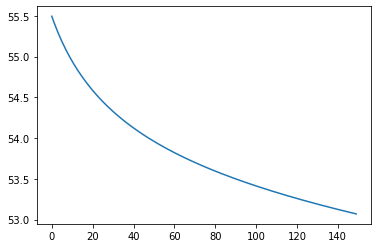

In [55]:
sparse_tls_cov_errors.plot()

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

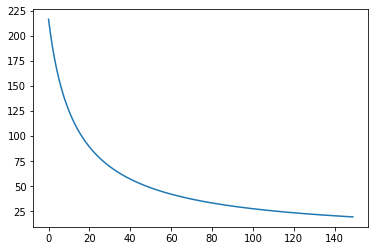

In [56]:
sparse_tls_cov_targets.plot()

# Result analysis

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


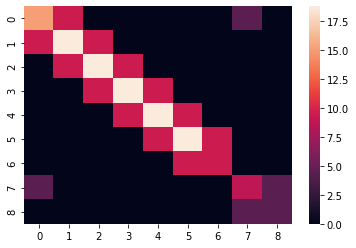

In [57]:
sns.heatmap(np.abs(y_bus));

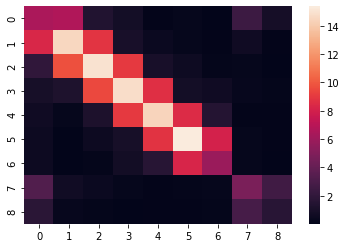

In [58]:
sns.heatmap(np.abs(y_bus - y_ols));

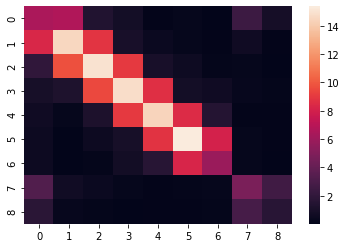

In [59]:
sns.heatmap(np.abs(y_bus - y_lasso));

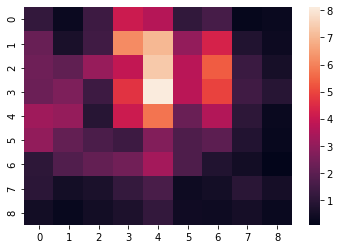

In [60]:
sns.heatmap(np.abs(y_bus - y_tls));

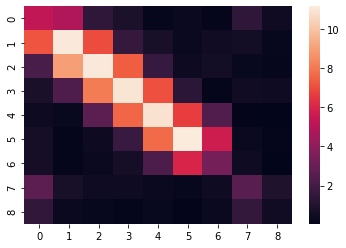

In [61]:
sns.heatmap(np.abs(y_bus - y_sparse_tls));

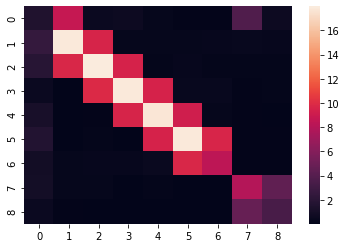

In [62]:
sns.heatmap(np.abs(y_bus - y_sparse_tls_cov));

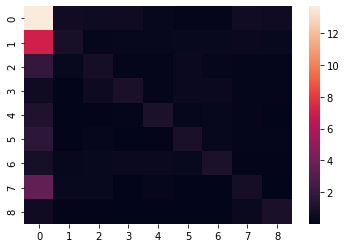

In [63]:
sns.heatmap(np.abs(y_sparse_tls_cov.toarray()));